In [1]:
# Next steps:
# 1) DONE - normalise generation (days in month, gross generation, degradation)
# 2) DONE - plot correlation
# 3) remove outliers
# 4) DONE - linear fit and synthesise generation
# 5) DONE - LT corrections
# 6) DONE - P50 output with availability shown

# Improvements:
# DONE - ERA5 download for whole of world to speed up results
# PARTIAL - EIA download for all plants to speed up results
# Review other fits: https://realpython.com/linear-regression-in-python/
# MERRA2 included as well
# Cover wind and solar
# Degradation analysis
# Simple front-end
# Examples
# Documentation
# Extend to other open generation datasets 

In [2]:
# load system packages
import os
from pathlib import Path

# load custom packages (requirements)
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from scipy import stats


# load local packages
from downloader import get_era5_monthly, get_EIA_plant_information, get_EIA_plant_generation

# load environment variables
load_dotenv()
EIA_API_KEY = os.environ["EIA_API_KEY"]



In [3]:
# get EIA plant information for wind assets
plant_info_file=Path("data/plant_list.csv").resolve()
if not plant_info_file.is_file():
    df_plant = get_EIA_plant_information(EIA_API_KEY)
    df_plant.to_csv(plant_info_file)
else:
    df_plant = pd.read_csv(plant_info_file)

print(df_plant)



      Unnamed: 0   period stateid   stateName       sector   sectorName  \
0              0  2023-05      TX       Texas  ipp-non-chp  IPP Non-CHP   
1              1  2023-05      IL    Illinois  ipp-non-chp  IPP Non-CHP   
2              2  2023-05      IL    Illinois  ipp-non-chp  IPP Non-CHP   
3              3  2023-05      NM  New Mexico  ipp-non-chp  IPP Non-CHP   
4              4  2023-05      NM  New Mexico  ipp-non-chp  IPP Non-CHP   
...          ...      ...     ...         ...          ...          ...   
1518        1518  2023-05      MI    Michigan  ipp-non-chp  IPP Non-CHP   
1519        1519  2023-05      KS      Kansas  ipp-non-chp  IPP Non-CHP   
1520        1520  2023-05      KS      Kansas  ipp-non-chp  IPP Non-CHP   
1521        1521  2023-05      KS      Kansas  ipp-non-chp  IPP Non-CHP   
1522        1522  2023-05      TX       Texas  ipp-non-chp  IPP Non-CHP   

      entityid                          entityName  plantid  \
0        58998              Chapman 

In [4]:
# select an EIA plant for analysis
selected_plant = df_plant.iloc[1]
print(selected_plant)


Unnamed: 0                                                 1
period                                               2023-05
stateid                                                   IL
stateName                                           Illinois
sector                                           ipp-non-chp
sectorName                                       IPP Non-CHP
entityid                                               56421
entityName                       Blackstone Wind Farm II LLC
plantid                                                57113
plantName                        Blackstone Wind Farm II LLC
generatorid                                            GEN 1
technology                              Onshore Wind Turbine
energy_source_code                                       WND
energy-source-desc                                      Wind
prime_mover_code                                          WT
balancing_authority_code                                 PJM
balancing-authority-name

In [5]:

# get the EIA generation for the selected plant
plant_data_file=Path(f"data/plant_generation_{selected_plant['plantid']}.csv").resolve()
if not plant_data_file.is_file():
    df_generation = get_EIA_plant_generation(EIA_API_KEY,plantCode=selected_plant["plantid"])
    df_generation.to_csv(plant_data_file)
else:
    df_generation = pd.read_csv(plant_data_file)

# set index to converted datetime
df_generation = df_generation.set_index("period")
df_generation.index = pd.to_datetime(df_generation.index)
print(df_generation)



            Unnamed: 0  plantCode                    plantName fuel2002  \
period                                                                    
2021-12-01           0      57113  Blackstone Wind Farm II LLC      WND   
2021-11-01           1      57113  Blackstone Wind Farm II LLC      WND   
2021-10-01           2      57113  Blackstone Wind Farm II LLC      WND   
2021-09-01           3      57113  Blackstone Wind Farm II LLC      WND   
2021-08-01           4      57113  Blackstone Wind Farm II LLC      WND   
...                ...        ...                          ...      ...   
2010-12-01         132      57113  Blackstone Wind Farm II LLC      WND   
2010-11-01         133      57113  Blackstone Wind Farm II LLC      WND   
2010-10-01         134      57113  Blackstone Wind Farm II LLC      WND   
2010-09-01         135      57113  Blackstone Wind Farm II LLC      WND   
2010-08-01         136      57113  Blackstone Wind Farm II LLC      WND   

           fuelTypeDescr

In [6]:
# get era5 data for the selected plant
df_era5 = get_era5_monthly(
    lat=selected_plant["latitude"],
    lon=selected_plant["longitude"]%360,
    save_pathname="data",
    save_filename=selected_plant["plantid"],
    data_pathname="data/era5_monthly",
    data_filename="era5_monthly",
    start_date="2000-01",
)

print(df_era5)

            windspeed_ms
datetime                
2000-01-01      4.219223
2000-02-01      4.407962
2000-03-01      3.918223
2000-04-01      3.929246
2000-05-01      4.040654
...                  ...
2023-04-01      4.373532
2023-05-01      3.557866
2023-06-01      3.409114
2023-07-01      2.631998
2023-08-01      3.138621

[284 rows x 1 columns]


In [7]:
# combine wind speed and generation into single dataframe
df = pd.concat([df_era5[["windspeed_ms"]],df_generation[["generation","gross-generation"]]],axis=1)

# add month number column
df["month"] = df.index.to_series().dt.month

# add days in month column
df["days-in-month"] = df.index.to_series().dt.days_in_month

# add availability column
df["availability-reported"] = df["generation"]/df["gross-generation"]

# add normalised generation column
df["generation-normalised"] = df["gross-generation"]*30/df["days-in-month"]

print(df.tail(20))


            windspeed_ms  generation  gross-generation  month  days-in-month  \
2022-01-01      4.217452         NaN               NaN      1             31   
2022-02-01      4.733000         NaN               NaN      2             28   
2022-03-01      4.332559         NaN               NaN      3             31   
2022-04-01      4.956857         NaN               NaN      4             30   
2022-05-01      4.301798         NaN               NaN      5             31   
2022-06-01      3.333897         NaN               NaN      6             30   
2022-07-01      3.147700         NaN               NaN      7             31   
2022-08-01      3.021332         NaN               NaN      8             31   
2022-09-01      3.233796         NaN               NaN      9             30   
2022-10-01      4.139996         NaN               NaN     10             31   
2022-11-01      4.610225         NaN               NaN     11             30   
2022-12-01      4.444456         NaN    

In [8]:

df_concurrent = df.copy()
df_concurrent = df_concurrent.dropna(subset=["windspeed_ms","generation-normalised"])

print(df_concurrent)


            windspeed_ms  generation  gross-generation  month  days-in-month  \
2010-08-01      2.507124     2877.00           2877.00      8             31   
2010-09-01      3.842653    23628.00          23628.00      9             30   
2010-10-01      3.913650    39593.00          39593.00     10             31   
2010-11-01      4.162776    59506.00          59551.00     11             30   
2010-12-01      3.921220    50388.00          50505.00     12             31   
...                  ...         ...               ...    ...            ...   
2021-08-01      2.698300    22447.84          22503.87      8             31   
2021-09-01      3.693215    39964.27          40064.02      9             30   
2021-10-01      3.651588    43604.64          43713.48     10             31   
2021-11-01      4.191844    58228.13          58373.48     11             30   
2021-12-01      4.225758    59986.34          60136.07     12             31   

            availability-reported  gene

In [9]:

# apply linear fit
res = stats.linregress(x=df_concurrent["windspeed_ms"],y=df_concurrent["generation-normalised"])

print(f"Slope: {res.slope}")
print(f"Intercept: {res.intercept}")
print(f"R-squared: {res.rvalue**2:.6f}")

# synthesise generation
df_concurrent["generation-synthesised"] = res.intercept + res.slope*df_concurrent["windspeed_ms"]
df["generation-synthesised"] = res.intercept + res.slope*df["windspeed_ms"]


Slope: 23679.64282662881
Intercept: -47969.80598707147
R-squared: 0.901515


In [10]:
# mean of monthly means
momm_concurrent = df_concurrent.groupby("month").mean() 
momm = df.groupby("month").mean()

# long-term resource adjustment
momm["resource-adjustment"] = momm["generation-synthesised"]/momm_concurrent["generation-synthesised"]

print(momm_concurrent[["generation-normalised","generation-synthesised"]])
print(momm[["generation-normalised","generation-synthesised","resource-adjustment"]])




       generation-normalised  generation-synthesised
month                                               
1               52820.050733            51347.023438
2               52782.206326            52734.148438
3               52868.677126            50692.761719
4               55235.773636            54319.238281
5               40477.209677            42574.398438
6               31309.899091            33242.679688
7               19143.197947            19312.517578
8               15984.597581            15985.062500
9               28639.444167            32706.203125
10              42480.273387            46382.683594
11              56209.232500            52004.187500
12              49408.741935            46023.824219
       generation-normalised  generation-synthesised  resource-adjustment
month                                                                    
1               52820.050733            50813.792969             0.989615
2               52782.206326        

In [11]:
# long-term monthly
momm["reported-availability"] = momm["generation"]/momm["gross-generation"]
momm["gross-generation-long-term"] = momm["gross-generation"]*momm["resource-adjustment"]
momm["net-generation-long-term"] = momm["gross-generation-long-term"]*momm["reported-availability"]

print(momm[["gross-generation-long-term","reported-availability","net-generation-long-term"]])

       gross-generation-long-term  reported-availability  \
month                                                      
1                    54013.906092               0.997798   
2                    49297.767075               0.997956   
3                    55094.911682               0.997850   
4                    56738.106758               0.998255   
5                    43233.448034               0.997861   
6                    30187.174567               0.996836   
7                    20888.472674               0.993512   
8                    19450.013402               0.992494   
9                    27083.840670               0.996761   
10                   43439.447313               0.997666   
11                   55747.573594               0.998264   
12                   54474.844979               0.997915   

       net-generation-long-term  
month                            
1                  53894.984940  
2                  49197.000476  
3                  5497

In [12]:
# P50 estimate
p50 = momm[["generation","gross-generation","gross-generation-long-term","net-generation-long-term"]].sum()
p50["resource-adjustment"] = p50["gross-generation-long-term"]/p50["gross-generation"]
p50["availability"] = p50["net-generation-long-term"]/p50["gross-generation-long-term"]
p50["r-squared"] = res.rvalue**2
print(p50)

generation                    502144.017879
gross-generation              503419.811212
gross-generation-long-term    509649.506841
net-generation-long-term      508343.362939
resource-adjustment                1.012375
availability                       0.997437
r-squared                          0.901515
dtype: float64


            windspeed_ms  generation  gross-generation  month  days-in-month  \
2010-08-01      2.507124     2877.00           2877.00      8             31   
2010-09-01      3.842653    23628.00          23628.00      9             30   
2010-10-01      3.913650    39593.00          39593.00     10             31   
2010-11-01      4.162776    59506.00          59551.00     11             30   
2010-12-01      3.921220    50388.00          50505.00     12             31   
...                  ...         ...               ...    ...            ...   
2021-08-01      2.698300    22447.84          22503.87      8             31   
2021-09-01      3.693215    39964.27          40064.02      9             30   
2021-10-01      3.651588    43604.64          43713.48     10             31   
2021-11-01      4.191844    58228.13          58373.48     11             30   
2021-12-01      4.225758    59986.34          60136.07     12             31   

            availability-reported  gene

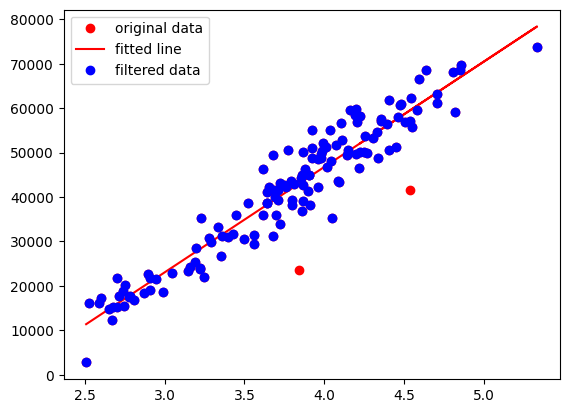

In [13]:
# detect and plot outliers for review
df_concurrent["residuals"] = df_concurrent["generation-normalised"]-df_concurrent["generation-synthesised"]
df_concurrent["outlier"] = df_concurrent["residuals"].abs() > 3*df_concurrent["residuals"].std()

df_filtered = df_concurrent.loc[df_concurrent["outlier"]==False] 

print(df_concurrent)

plt.plot(df_concurrent["windspeed_ms"], df_concurrent["generation-normalised"], 'ro', label='original data')
plt.plot(df_concurrent["windspeed_ms"], df_concurrent["generation-synthesised"], 'r', label='fitted line')
plt.plot(df_filtered["windspeed_ms"], df_filtered["generation-normalised"], 'bo', label='filtered data')
plt.legend()


In [14]:
# from sklearn.neighbors import LocalOutlierFactor
# import numpy as np

# clf = LocalOutlierFactor(n_neighbors=2)
# clf.fit_predict(df_concurrent)
# df_concurrent["clf"]=clf.negative_outlier_factor_
# print(df_concurrent)
# df_concurrent.to_clipboard()
#np.mean(np.std(clf.negative_outlier_factor_))-5*np.std(clf.negative_outlier_factor_)

In [15]:

# fig, ax = plt.subplots(figsize=(20,10)) 
# df.plot(y = "generation", ax = ax) 
# df.plot(y = "gross-generation", ax = ax) 
# df.plot(y = "windspeed_ms", ax = ax, secondary_y = True) 
# plt.show()

#fig, ax = plt.subplots(figsize=(20,10)) 
#df.plot.scatter(x="windspeed_ms",y="generation-normalised",ax=ax)


In [16]:
# clustering = DBSCAN(eps=3, min_samples=2).fit(df_concurrent[["windspeed_ms","generation-normalised"]])

# print(clustering.labels_)